# Verification Experiment for WindLog Sensors



## Introduction
Reliably measuring wind speeds within overwintering groves is an important component of my master's no matter what direction it takes.

Francis has up to 40 anemometers that log data available for my study. The only issue is that they were unreliable in the previous studies they were used. 

I have two on loan which I want to see if they can reliably record measurements. This notebook is the results of that effort. 

## Experimental Design
In a closed room with no open windows or doors, I set up an oscillating fan blowing into the center of the room. The fan is a tower style home fan that is much taller than it is wide. 

I tied a string to the center of the fan and allowed the fan to oscillate all the way to the right. Here I placed one of the windLog instruments (FunStorm) as close as I could to the fan, which was sitting atop my dresser. I tied a knot in the string where the front of the wind instrument was placed. I did this so I could place the other two sensors nearly the same distance away from the fan. 

I allowed the fan to oscillate to the far left, where I placed the second windLog insturment (LlamaLog), being careful to align the instrument so that is the same distance away as LlamaLog using the string. I completed the placement by putting the kestrel in the center using the string. 

The length of string that was used is approximately 0.40 m. The height of the sensors was 1.65 m. 

The fan was set to full speed, and the door was closed. The trial period began at 11:35 AM on July 30th, 2023. The trial ended sometime around 5:30 PM the same day. The fan was turned off, but data collection continued while I wrote this and downloaded the data.

All sensors were set to record wind measurements every minute. Both wind log meters were free of any cables during the data collection period. 

Data was downloaded from the windLog instruments using the default software on my work laptop (Windows). At the time of download, LlamaLog had 4.6V reading, and LlamaLog had 4.3V.

Curiously, The LlamaLog instrument recording a spike in wind measurements when I connected to the computer. This was mirrored in previous experiments. LlamaLog did not have this problem.

## Cleaning The Data

Below I load the measurements from the three datasets and prepare them for comparison. 

###  Kestrel
To start, we'll begin with the Kestrel sensor, which will have it's own peculiarities compared to the WindLog sensors.

In [1]:
import pandas as pd

kestrel = pd.read_csv('data/kestrel20230730.csv',skiprows=5,header=None) # skip rows that are not data
kestrel = kestrel[[0,1,3,7]] # Drop empty columns
kestrel.columns = ['time','temp','humidity','wind_speed'] # Rename columns
kestrel['time'] = pd.to_datetime(kestrel['time']) # Convert time to datetime
kestrel.tail()

/var/folders/ww/j283g5cd3bd9k7z7_f2mxslc0000gn/T/ipykernel_60203/2201296229.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  kestrel['time'] = pd.to_datetime(kestrel['time']) # Convert time to datetime


,time,temp,humidity,wind_speed
1069,2023-07-30 17:11:00,80.6,51.1,0.0
1070,2023-07-30 17:12:00,80.6,51.3,0.0
1071,2023-07-30 17:13:00,80.7,51.4,0.0
1072,2023-07-30 17:14:00,81.0,51.7,0.0
1073,2023-07-30 17:15:00,80.9,51.7,0.0


Now that I have the dataframe cleaned, I need to filter the rows to the time of the experiment, since this goes back too far and has many 0 values. I took a note that I started the experiment around 11:35, so we can start there.

It's worth noting that I am only interested in wind speed at this time, but kept temp and humidity in there in case it might shed some light if anything unusual pops up.

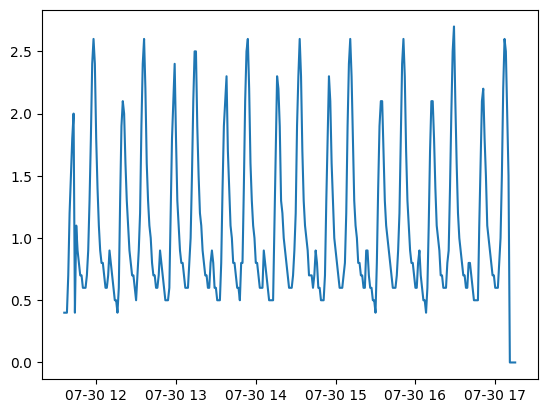

In [2]:
import matplotlib.pyplot as plt

# Remove all rows that occurred before 11:45 am on 2023-07-30
kestrel = kestrel[kestrel['time'] > '2023-07-30 11:35:00']
# Plot wind speed along time axis
plt.plot(kestrel['time'], kestrel['wind_speed'])

That looks pretty good, but there's some weirdness on either end of the plot. I'm going to consider observations 10 mins after the start, and 10 mins before the first 0 value. This will avoid edge effects, and I think I'll still have plenty of data to work with.

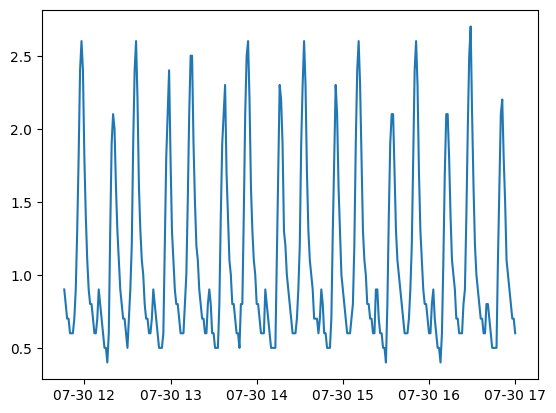

In [3]:
# # Filter out the first 10 mins of data
kestrel = kestrel[kestrel['time'] > '2023-07-30 11:45:00']

# Find the first time the wind speed is below 0.1 m/s
end_time = kestrel['time'][kestrel['wind_speed'] < 0.1].head(1)
end_time = end_time - pd.Timedelta(minutes=10)
kestrel = kestrel[kestrel['time'] < end_time.values[0]]

plt.plot(kestrel['time'], kestrel['wind_speed'])

That looks great. I think we can move on to cleaning the WindLog sensors.

### FunStorm

Moving on to the first of the two windLog sensors

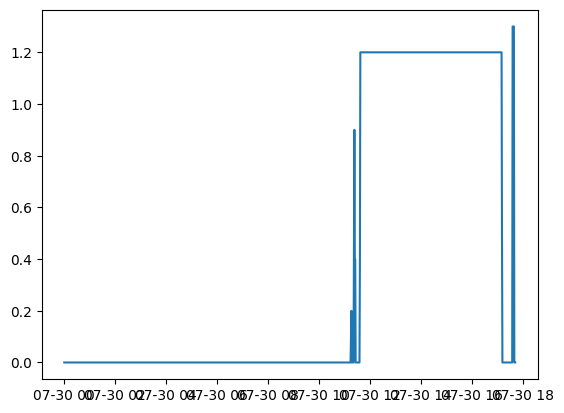

In [4]:
FunStorm = pd.read_csv('data/FunStorm20230730.csv',skiprows=7,header=None) # Skips non-data rows
FunStorm = FunStorm[[0,1,2]] # Drop direction column, keep time, speed, and gust
FunStorm.columns = ['time','wind_speed','gust'] # Rename columns
FunStorm['time'] = pd.to_datetime(FunStorm['time'],format='%m/%d/%Y %I:%M %p') # Convert time to datetime
# Plot wind speed and gust
plt.plot(FunStorm['time'],FunStorm['wind_speed'],label='Wind Speed')

Looks like the code was read in correctly, but we need to also clean all the extra observations outside our experiment window. 

Let's see how close the sensor times are, and use the earliest and latest observation from kestrel to set the rows. 

Kestrel start time:  2023-07-30 11:46:00
Kestrel end time:  2023-07-30 17:00:00


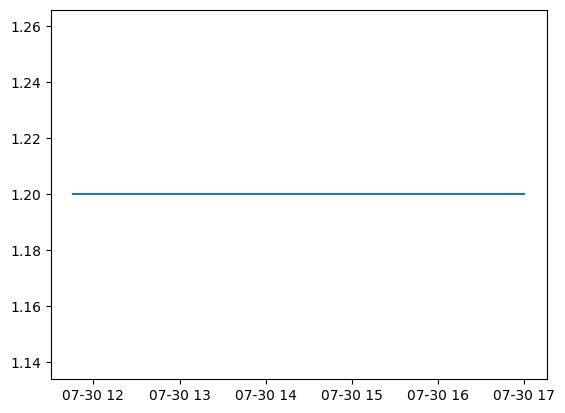

In [5]:
# Get kestrel first and last time stamp
start_time = kestrel['time'].iloc[0]
end_time = kestrel['time'].iloc[-1]

print('Kestrel start time: ', start_time)
print('Kestrel end time: ', end_time)
# filter FunStorm based on start and end time
FunStorm = FunStorm[(FunStorm['time'] >= start_time) & (FunStorm['time'] <= end_time)]

# Plot FunStorm
plt.plot(FunStorm['time'],FunStorm['wind_speed'],label='Wind Speed')


Well that straight line looks awfully promising! Clearly the WindLog is averaging the values across the minute, while the kestrel is simply reporting the value at the time of logging. We can test this idea by plotting gusts and see if we can see the oscillating pattern like we do in the kestrel data. 

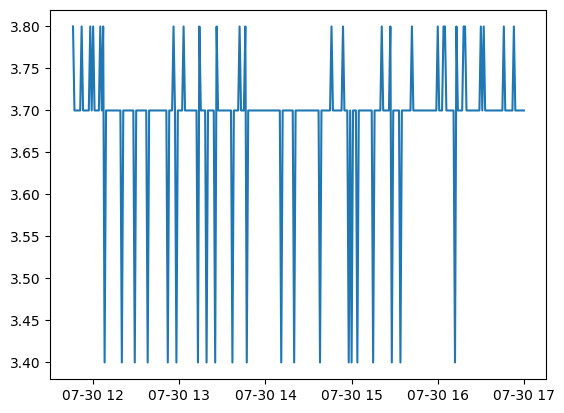

In [6]:
# plot gust data for FunStorm
plt.plot(FunStorm['time'],FunStorm['gust'],label='gust')

That looks like it's oscillating, but not at the same resolution as the kestrel. Maybe it can only record at 10ths of m/s? Probably fine for my project. 


### LlamaLog
Moving on to the final instrument.

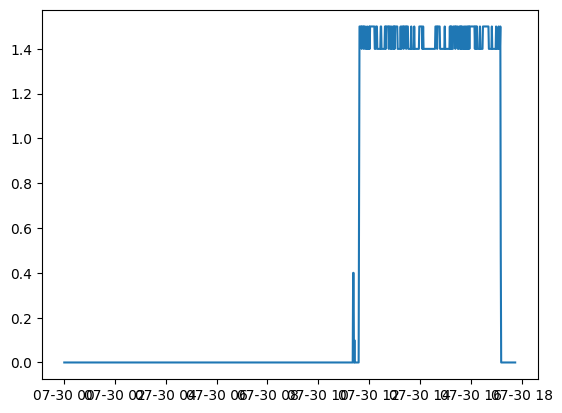

In [7]:
LlamaLog = pd.read_csv('data/LlamaLog20230730.csv',skiprows=7,header=None) # Skips non-data rows
LlamaLog = LlamaLog[[0,1,2]] # Drop direction column, keep time, speed, and gust
LlamaLog.columns = ['time','wind_speed','gust'] # Rename columns
LlamaLog['time'] = pd.to_datetime(LlamaLog['time'],format='%m/%d/%Y %I:%M %p') # Convert time to datetime
# Plot wind speed and gust
plt.plot(LlamaLog['time'],LlamaLog['wind_speed'],label='Wind Speed')

Looks like we need the same proceedure to remove the extra rows. Done below.

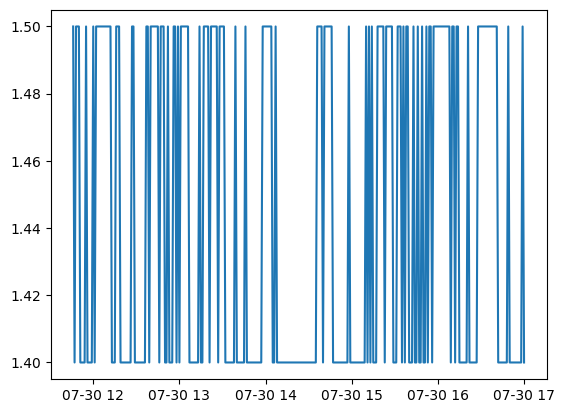

In [8]:
# filter FunStorm based on start and end time
LlamaLog = LlamaLog[(LlamaLog['time'] >= start_time) & (LlamaLog['time'] <= end_time)]

# Plot LlamaLog
plt.plot(LlamaLog['time'],LlamaLog['wind_speed'],label='Wind Speed')

That looks good. Let's also plot gust values.

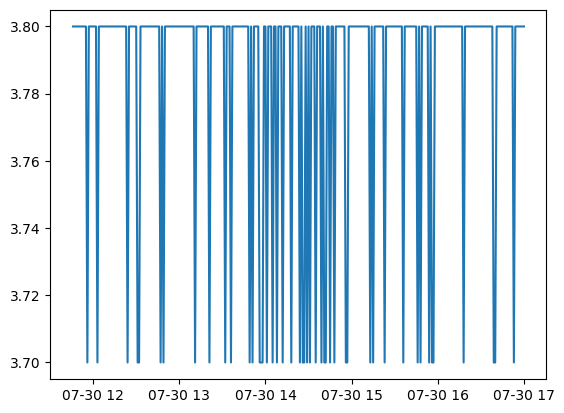

In [9]:
# plot gust data for LlamaLog
plt.plot(LlamaLog['time'],LlamaLog['gust'],label='gust')

Great. Now that we have all the datasets clean, let's combine them so we can start our analysis. 

### Combining the datasets


In [10]:
# Give each dataframe a column to identify the source
kestrel['source'] = 'kestrel'
FunStorm['source'] = 'FunStorm'
LlamaLog['source'] = 'LlamaLog'
# Combine kestrel, FunStorm, and LlamaLog dataframes into one dataframe
df = pd.concat([kestrel, FunStorm, LlamaLog], axis=0, ignore_index=True)
df.to_csv('data/combined20230730.csv')
df

,time,temp,humidity,wind_speed,source,gust
0,2023-07-30 11:46:00,75.4,54.0,0.9,kestrel,NaN
1,2023-07-30 11:47:00,75.4,54.0,0.8,kestrel,NaN
2,2023-07-30 11:48:00,75.5,53.9,0.7,kestrel,NaN
3,2023-07-30 11:49:00,75.4,53.9,0.7,kestrel,NaN
4,2023-07-30 11:50:00,75.4,53.9,0.6,kestrel,NaN
...,...,...,...,...,...,...
940,2023-07-30 16:56:00,NaN,NaN,1.4,LlamaLog,3.8
941,2023-07-30 16:57:00,NaN,NaN,1.4,LlamaLog,3.8
942,2023-07-30 16:58:00,NaN,NaN,1.4,LlamaLog,3.8
943,2023-07-30 16:59:00,NaN,NaN,1.5,LlamaLog,3.8


Just for fun, let's plot wind speed for all the sources.

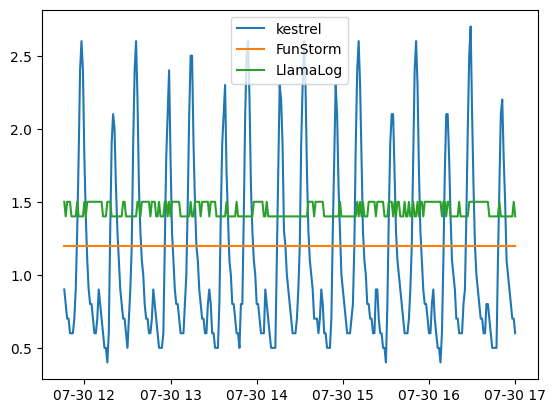

In [11]:
# get unique sources
sources = df['source'].unique()

# for each source, plot a line with a label
for source in sources:
    subset = df[df['source'] == source]
    plt.plot(subset['time'], subset['wind_speed'], label=source)

plt.legend()
plt.show()

That looks surprisingly close. If you were to run the averages I imagine they will be near each other. 

The next section we'll explore that in a more robust way.

## Statistically Analysis

### Testing to see if the three sensors agree

The first and most obvious test is to see if the three sensors mean values are the same or not. To test this I will run a one-way ANOVA to determine if there are significant differences between the sensors. Before I test my assumptions:

1. Normality test
2. Variance Homogenity Test

Let's start with the normality test.

#### Normality Test

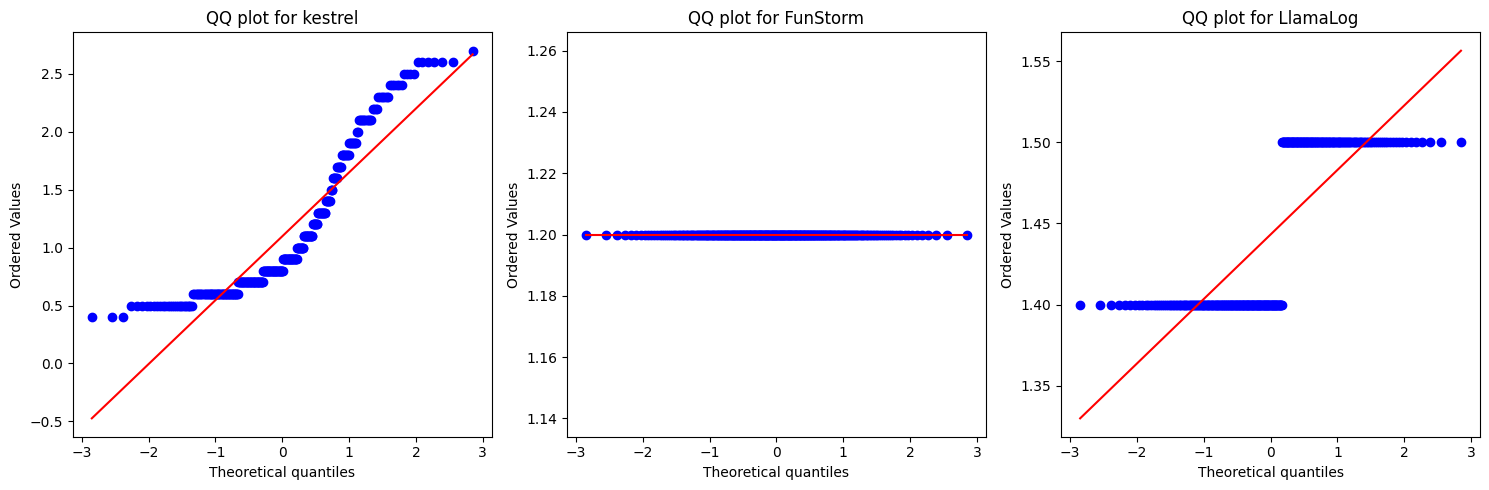

/Users/kylenessen/opt/anaconda3/envs/geospatialAnalysis/lib/python3.10/site-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


{'kestrel': ShapiroResult(statistic=0.839111328125, pvalue=1.9162595110578997e-17),
 'FunStorm': ShapiroResult(statistic=1.0, pvalue=1.0),
 'LlamaLog': ShapiroResult(statistic=0.6296782493591309, pvalue=1.53880249486633e-25)}

In [12]:
from scipy import stats
import numpy as np

# Create QQ plots
plt.figure(figsize=(15, 5))

for i, source in enumerate(df['source'].unique(), 1):
    plt.subplot(1, 3, i)
    stats.probplot(df[df['source'] == source]['wind_speed'], plot=plt)
    plt.title(f'QQ plot for {source}')

plt.tight_layout()
plt.show()

# Perform Shapiro-Wilk test
shapiro_results = {}

for source in df['source'].unique():
    shapiro_results[source] = stats.shapiro(df[df['source'] == source]['wind_speed'])

shapiro_results


Looking at the QQ plots (Quantile-Quantile), we are checking to see if the datasets follow a normal distribution. The blue points represent our observed data, and how well they correlate with the red line indicates how well they fit a normal distribution. 

Kestrel and LlamaLog do a poor job of fitting the line, but FunStorm seems to fit. However, all the values are same in this dataset, so it is not normally distributed, but rather uniformly distributed. 

I also ran a Shapiro-Wilk test to test formally if the data follow a normal distribution. The very low p values for kestrel and LlamaLog indicate we can reject the the hypothesis that they are normally distributed. We can also reject FunStorm because Shapiro-Wilk does not give meaningful results for datasets that have zero variance. 

#### Testing for Uniform Distribution

Just out of curiosity, I want to see if the datasets are uniformly distributed. Because of the nature of the experiment (oscillating wind going back and forth), I would expect the values to be more or less uniform. 

I'm going to perform a Kolmogorov-Smirnov test to try this idea.

Also note: I do not test for FunStorm because the variance is zero, and therefore we can't perform these kinds of tests.

In [13]:
# Perform Kolmogorov-Smirnov test for uniform distribution
ks_results = {}

for source in ['LlamaLog', 'kestrel']:
    sensor_data = df[df['source'] == source]['wind_speed']
    ks_results[source] = stats.kstest(sensor_data, 'uniform', args=(sensor_data.min(), sensor_data.max()))

ks_results


{'LlamaLog': KstestResult(statistic=0.9333333333333332, pvalue=0.0, statistic_location=1.5, statistic_sign=1),
 'kestrel': KstestResult(statistic=0.416931216931217, pvalue=4.1489698950433963e-50, statistic_location=1.1, statistic_sign=1)}

The p-values are exceptionally low, indicating that the datasets are NOT uniformly distributed. Oh well.

#### Variance Homogeneity Test

Next we'll check the assumption of homogeneity of variance using Levene's test. This will check whether variance of the difference sensors is equal. I don't expect this will pass, however, as we saw earlier that WindLog sensors are reporting averages, while the kestrel is reporting instantaneous results. 

Future calibrations should have the kestrel report at much higher intervals so averages can be found later. 

In [14]:
levene_test = stats.levene(
    df[df['source'] == 'FunStorm']['wind_speed'],
    df[df['source'] == 'LlamaLog']['wind_speed'],
    df[df['source'] == 'kestrel']['wind_speed']
)

levene_test

LeveneResult(statistic=228.61852137112467, pvalue=1.1565802562225169e-81)

As expected, the p-value is vanishingly small, indicating that we cannot conclude the variances are equal. 

We can try just the two windLog sensors, but I suspect this might not work either, because FunStorm has 0 variance.

In [15]:
levene_test = stats.levene(
    df[df['source'] == 'FunStorm']['wind_speed'],
    df[df['source'] == 'LlamaLog']['wind_speed']
)

levene_test

LeveneResult(statistic=238.56983240223462, pvalue=7.414701208707865e-46)

Again, also fails.

#### Kruskal-Wallis Test

Given that the variance is not equal no matter how we look at it, we need to do a non-parametric test to compare the wind speeds. This will test to see whether samples originate from the same distribution. Allowing us to compare two or more independent samples. 

In [16]:
# Perform Kruskal-Wallis test
kruskal_test = stats.kruskal(
    df[df['source'] == 'FunStorm']['wind_speed'],
    df[df['source'] == 'LlamaLog']['wind_speed'],
    df[df['source'] == 'kestrel']['wind_speed']
)

kruskal_test

KruskalResult(statistic=388.1563516999093, pvalue=5.163202644714e-85)

The p-value again, is essentially zero. This indicates that the samples do not come from the same distribution. Again, probably because of the pitfalls identified before. 

#### Dunn's Test

All the assumptions have failed, indicating that at least one sensor is different than the other. In order to find out more, we can use Dunn's Test to do a pair wise comparison of all the sensors to see which are different from each other. 

In [18]:
import scikit_posthocs as sp
p_values = sp.posthoc_dunn(df, val_col='wind_speed', group_col='source', p_adjust='holm')

print(p_values)

              FunStorm      LlamaLog       kestrel
FunStorm  1.000000e+00  6.885392e-57  3.932402e-02
LlamaLog  6.885392e-57  1.000000e+00  5.956021e-72
kestrel   3.932402e-02  5.956021e-72  1.000000e+00


Turns out they are all distinct and different. 

I don't think this is necessarily bad, and can be explained by the experimental setup. While I tried to get the distance between each sensor equal to the fan, I did not spend much thought and making sure they all experienced the same *duration* of time in the direct line of sight of the fan. I also gave little concern to how frequently the fan intersected the sensor. I tried to account for this by putting the two WindLogs on the edges, and the kestrel in the middle. 

In any case I think we can stop here to see if they are all the same. My next question is whether they are taking measurements in a reliable way. While each sensor experiences a slightly different condition, each sensor should have it repeat in a predictable way. 